<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

### What is the Higgs boson?
The Higgs boson is a fundamental particle predicted by the Standard Model. It is a manifestation of the Higgs field, which gives mass to fundamental particles. However, it is incredibly difficult to produce. At the LHC, a Higgs particle is produced about once every 10 billion collisions, making it very challenging to detect.

Despite this tiny fraction, years of data collection led to the discovery of the Higgs boson in 2012 by the CMS and ATLAS experiments at CERN. In this tutorial, we will follow their example.

### Detecting the Higgs
This analysis loosely follows the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (Section 5) and one of the subsequent ATLAS measurements making use of more data and allowing for more detailed studies: [Measurements of Higgs boson properties in the diphoton decay channel](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005) (Section 5).

The Higgs boson can be generated through various mechanisms. In particle physics, we use Feynman diagrams to illustrate these production modes. These diagrams help us visualize particle interactions and serve as essential tools for computations. For additional details on Feynman diagrams, see this [link](https://cds.cern.ch/record/2759490/files/Feynman%20Diagrams%20-%20ATLAS%20Cheat%20Sheet.pdf).

There are four primary production modes for the Higgs boson, each represented by its own Feynman diagram:
1. Gluon-gluon fusion (top left)
2. Vector boson fusion (top right)
3. Vector boson bremsstrahlung (bottom left)
4. Top-antitop fusion (bottom right)

<CENTER><img src="images/ImagesHiggs/ggH.png" style="width:40%"> <img src="images/ImagesHiggs/VBFH.png" style="width:35%"></CENTER>
<CENTER><img src="images/ImagesHiggs/WH.png" style="width:40%"> <img src="images/ImagesHiggs/ttbarfusion.png" style="width:35%"></CENTER>


The Higgs boson has an extremely brief lifetime, approximately $10^{-22} \,\text{s}$. It decays almost immediately after it is produced, making direct detection of the particle impossible. However, by using the Standard Model, we can predict the various decay products of the Higgs, such as photons, Z bosons, quarks, and others, each occurring with different probabilities. These **decay channels** help us identify the presence of the Higgs boson. In this notebook, we will focus on analyzing one specific decay channel:
$$H \rightarrow \gamma\gamma$$

<CENTER><img src="images/feynman_diagrams/Hyy_feynman.png" style="width:40%"></CENTER>

We refer to this as our desired **signal**. Ideally, we aim to identify collisions that produce two photons, which would indicate the presence of a Higgs boson. However, along with our signal, many photons detected do not originate from Higgs boson decay but rather from other processes, forming the **background**.

Backgrounds are classified into two categories: reducible and irreducible. **Reducible backgrounds** can be significantly minimized using experimental techniques such as data cuts, particle identification, and isolation criteria. For instance, in our case, a reducible background might involve events where a jet is misidentified as a photon. By applying stricter criteria to ensure that the detected particles are indeed photons (and not misidentified jets), this background can be reduced.

On the other hand, irreducible backgrounds cannot be easily distinguished from the signal because they involve the same final states or processes that the signal would produce. In the scenario of Higgs decay into two photons, an **irreducible background** would be the direct production of two photons from other Standard Model processes, such as quark-antiquark annihilation. These events are fundamentally indistinguishable from the signal events based on final state particles alone.

    
To address this, we can consider the total invariant mass of the photon products. By conservation of energy and momentum, the invariant mass of the products must equal the Higgs mass, whereas other background processes will have different invariant masses. The final step is to plot the invariant mass of each event and identify the peak around 125 GeV, which corresponds to the mass of the Higgs boson.

By the end of this notebook you will be able to:
1. Learn to process large data sets using cuts
2. Understand some general principles of a particle physics analysis
3. Discover the Higgs boson!

See [here](https://cds.cern.ch/record/2800577/files/Signal%20and%20Background%20Physics%20Cheat%20Sheet.pdf) for more information on signals and backgrounds!

### Running a Jupyter notebook
A Jupyter notebook consists of cell blocks, 
    each containing lines of Python code.
Each cell can be run independently of each other,
    yielding respective outputs below the cells.
Conventionally,
    cells are run in order from top to bottom.


- To run the whole notebook, in the top menu click Cell $\to$ Run All.

- To propagate a change you've made to a piece of code, click Cell $\to$ Run All Below.

- You can also run a single code cell, by clicking Cell $\to$ Run Cells, or using the keyboard shortcut Shift+Enter.

For more information, 
    refer to [here](https://www.codecademy.com/article/how-to-use-jupyter-notebooks).

## ATLAS Open Data Initialisation

### First time package installation on your computer (not needed on mybinder)
This first cell installs the required python packages.
It only needs to be run the first time you open this notebook on your computer. 
If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.
If this is opened on mybinder, you don't need to run this cell.

In [ ]:
#install required packages
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy==2.0.0 pandas==2.2.2 uproot==5.3.9 matplotlib==3.9.0 lmfit==1.3.1 awkward-pandas==2023.8.0 aiohttp==3.9.5 requests==2.32.3 --user

### To setup everytime
We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us handle complex and nested data structures efficiently
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* lmfit: tool for statistical fitting

In [2]:
import uproot # for reading .root files
import time # to measure time to analyse
import math # for mathematical functions such as square root
import awkward as ak # for handling complex and nested data structures efficiently
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import vector #to use vectors
import requests # for HTTP access
import aiohttp # HTTP client support

## Example 1: Reading data 

We would like to read some of the data from the open dataset.

In [3]:
# ATLAS Open Data directory
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/GamGam/Data/" # web address

#tuple_path = \"~/Downloads/GamGamNew/\" # local

The data is organized by the collection periods throughout the year. In this notebook, we will use the 2015 data from periods D, E, F, G, H, and J, as well as the 2016 data from periods A, B, C, D, E, F, G, K, and L.

In [4]:
samples_list = ['data15_periodD','data15_periodE','data15_periodF','data15_periodG','data15_periodH','data15_periodJ','data16_periodA','data16_periodB','data16_periodC','data16_periodD','data16_periodE','data16_periodF','data16_periodG','data16_periodK','data16_periodL']

Let's try accessing `data15_periodG` in the ATLAS Open Data directory as an example.

In [ ]:
print(samples_list[3])

# This is now appended to our file path to retrieve the data15_periodG.root file
data_15G_path = path + samples_list[3] + ".root"

Next, let's open the `data15_periodG` file to examine its contents. The file, known as a `tree`, contains multiple entries, each representing an event. For each event, a dictionary stores all relevant information with keys, such as the event number (`eventNumber`), the photon transverse momentum (`photon_pt`), and more.

Details on the variables in the dictionary can be viewed [here](https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf) in Appendix A.

More information on trees can be viewed [here](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) and [here](https://hsf-training.github.io/hsf-training-uproot-webpage/03-trees/index.html).

In [ ]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
with uproot.open(data_15G_path + ":analysis") as t:
    tree = t

# The number of entries in the tree can be viewed
print("The number of entries in the tree are:", tree.num_entries)

# All the information stored in the tree can be viewed using the .keys() method.
print("The information stored in the tree is:", tree.keys())

Perhaps we'd like to see the energies of the photons. 
We can access this from our tree using the key `photon_e`.

In [ ]:
tree["photon_e"].arrays()

Depending on the analysis, some variables are more revelant than others, providing directly or indirectly better discrimination of the signal with respect to the backgrounds than others.
The most important variables for the $H \rightarrow \gamma\gamma$ analysis can be stored in a list and retrieved later from the tree, and correspond to the following:

In [8]:
variables = ["photon_pt","photon_eta","photon_phi","photon_e",
                            "photon_isTightID","photon_ptcone20"]

Now that we understand how to access the information in the `data15_periodG` tree, we can begin our analysis. As mentioned in the introduction, there are two key steps to complete for each event entry:
1. **Cuts** - we need to account for photons selection rules in the event. 
Based on the [Higgs boson discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X) and the [Higgs boson decay to photons measurement paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005), one can define some main selection criteria: 
- Photon candidates are required to pass identification criteria because there is a risk of misidentifying jets and other particles that can mimic photon signals as actual photons.
- The leading (sub-leading) photon candidate is required to have $E_t$ (transverse energy) > 50 GeV (30 GeV) because background processes frequently generate photons with lower $E_t$. By setting these constraints, we can reduce the impact of background processes and thereby improve the signal-to-background ratio. Given that photons are massless particles, enforcing these requirements on transverse energy is effectively equivalent to enforcing them on transverse momentum.
- Photon candidates are required to have a calorimeter isolation, consisting on the sum of the transverse energies of energy clusters in the calorimeter around a spatial cone centered around the photon, in order to make sure the photons detected are not originating from jets. Additional photon transverse energy relative to the diphoton mass isolation is also required.
- Since the transition between the the barrel and end-cap of the calorimeter can introduce uncertainties in the energy measurements of particles this issue is resolved by excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52.

We need to filter the data such that in each event, the criteria mentioned above are satisfied.

2. **Mass calculation** - the data to be plotted is the di-photon invariant mass, which can be calculated using the equation: $$m_{\gamma\gamma} = \sqrt{E^2_\text{tot}-\mathbf{p}_\text{tot}\cdot\mathbf{p}_\text{tot}}$$
in units where $c=1$.
$E_\text{tot}$ is the total energy and $\mathbf{p}_\text{tot}$ is the total momentum.
This calculation is performed using the vector array method `.M` on the sum of the photon 4-momenta: (`photon_pt`,`photon_eta`,`photon_phi`,`photon_e`).

From this,
    we can see why we chose those six important variables earlier. 
Let's try to perform this two-step analysis for one event in `data15_periodG`.

In [ ]:
# This selects the first entry of the tree
entry = tree.arrays(library="ak")[:1]

# Cut on the photon reconstruction quality
photon_reconstruction = entry['photon_isTightID']
# isTightID==True means a photon identified as being well reconstructed, only the events which have True for both photons are kept
photon_reconstruction_cut_bool = (photon_reconstruction[:, 0] == False) | (photon_reconstruction[:, 1]==False) # [:, i] selects the i-th lepton in each event
print("The reconstruction quality of the two photons:", photon_reconstruction[:,0], photon_reconstruction[:,1])
print(f"Apply cut based on reconstruction quality requirements?{photon_reconstruction_cut_bool}")
    
# Cut on the transverse momentum
photon_pt = entry['photon_pt']
# Only the events where the leading photon has transverse momentum (pt) > 50 GeV and the sub-leading photon has pt > 30 GeV are kept
# Since the two photons for each entry are ordered, the first photon is the leading one and the second one is the sub-leading one
photon_pt_cut_bool = (photon_pt[:,0] < 50) | (photon_pt[:,1] < 30)
print("The transverse momentum of the two photons:", photon_pt[:,0], photon_pt[:,1])
print(f"Apply cut based on the transverse momentum requirements?{photon_pt_cut_bool}")

# Cut on the calorimeter isolation
photon_ptcone20 = entry['photon_ptcone20']
# Only the events where the invidivual photon calorimeter isolation is less than 5.5% are kept
photon_caloiso_cut_bool = (((photon_ptcone20[:,0]/photon_pt[:,0]) > 0.055) | ((photon_ptcone20[:,1]/photon_pt[:,1]) > 0.055))
print("The calorimeter isolation of the two photons:", (photon_ptcone20[:,0]/photon_pt[:,0]), (photon_ptcone20[:,1]/photon_pt[:,1]))
print(f"Apply cut based on the calorimeter isolation requirements?{photon_caloiso_cut_bool}")

# Cut on the pseudorapidity in the barrel/end-cap transition region
photon_eta = entry['photon_eta']
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) & (np.abs(photon_eta[:, 0]) > 1.37)
condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) & (np.abs(photon_eta[:, 1]) > 1.37)
photon_eta_cut_bool = (condition_0 | condition_1)
print("The eta of the two photons:", photon_eta[:,0], photon_eta[:,1])
print(f"Apply cut based on the eta requirements?{photon_eta_cut_bool}")

# This calculates the invariant mass of the 2-photon state
p4 = vector.zip({"pt": entry['photon_pt'], "eta": entry['photon_eta'], "phi": entry['photon_phi'], "e": entry['photon_e']})
invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
print(f"The invariant mass of the 2-photon state is: {invariant_mass} GeV")

# Cut on the invariant mass based isolation
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
photon_massiso_cut_bool = ((photon_pt[:,0]/invariant_mass) < 0.35) | ((photon_pt[:,1]/invariant_mass) < 0.35)
print("The invariant mass based isolation of the two photons:", (photon_pt[:,0]/invariant_mass), (photon_pt[:,1]/invariant_mass))
print(f"Apply cut based on the invariant mass based isolation requirements?{photon_massiso_cut_bool}")


Based on our analysis, this entry should be removed because the photons do not match all our requirements.
We can turn these checks and calculations into a set of functions.

In [10]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==False) | (photon_isTightID[:,1]==False) 

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] < 50) | (photon_pt[:,1] < 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[:,0]/photon_pt[:,0]) > 0.055) | ((photon_ptcone20[:,1]/photon_pt[:,1]) > 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) & (np.abs(photon_eta[:, 0]) > 1.37)
    condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) & (np.abs(photon_eta[:, 1]) > 1.37)
    return condition_0 | condition_1

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass == 0)

# Cut on diphoton invariant mass based isolation 
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[:,0]/invariant_mass) < 0.35) | ((photon_pt[:,1]/invariant_mass) < 0.35)

You may verify on your own that these functions give the same outputs as the previous code block.
Now, 
    we shall apply these functions over the entire data tree using a `for` loop.

In [11]:
# Define empty list to hold all data for this sample
sample_data = []

# Perform the cuts for each data entry in the tree
for data in tree.iterate(variables, library="ak"):
    
    # data[~boolean] is used to remove entries from the data set
    photon_isTightID = data['photon_isTightID']
    data = data[~cut_photon_reconstruction(photon_isTightID)]

    photon_pt = data['photon_pt']
    data = data[~cut_photon_pt(photon_pt)]

    data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

    photon_eta = data['photon_eta']
    data = data[~cut_photon_eta_transition(photon_eta)]
    
    data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])
    
    data = data[~cut_mass(data['mass'])]
        
    data = data[~cut_iso_mass(data['photon_pt'], data['mass'])]
    
    # Append data to the whole sample data list
    sample_data.append(data)

# turn sample_data back into an awkward array
data15_periodG = ak.concatenate(sample_data)

We can now plot the data using Matplotlib. 
The data will be turned into a histogram,
    with bins of width 3 GeV.
Note that much of the code written here is meant for the aesthetics of the plot.

In [ ]:
# x-axis range of the plot
xmin = 100 #GeV
xmax = 160 #GeV

# Histogram bin setup
step_size = 2 #GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(data15_periodG['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data


# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

Great,
    we managed to plot `data15_periodG`! 
Now that we have understood how to manage the data, apply the cuts and calculate the mass, we can proceed to analyze the data!

## Final Analysis

For the final analysis, we’ll begin by applying the cuts and calculating the invariant masses across all the data. Once that's done, we'll fit the data to uncover the Higgs boson peak. Let’s kick things off by applying the cuts and calculating those invariant masses!

In [ ]:
# Controls the fraction of all the events analysed
fraction = 1 # all of the data is used to run this analysis (implemented in the loop over the tree)
             # reduce this if you want the code to run quicker

all_data = []
sample_data = []

# Loop over each file
for val in samples_list: 

    # Print which sample is being processed
    print('Processing '+val+' samples')

    fileString = path + val + ".root" # file name to open

    # Open file
    with uproot.open(fileString + ":analysis") as t:
        tree = t
    
    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree and calculate the invariant mass
    for data in tree.iterate(variables, library="ak", entry_stop=numevents*fraction):
 
        photon_isTightID = data['photon_isTightID']
        data = data[~cut_photon_reconstruction(photon_isTightID)]
        
        photon_pt = data['photon_pt']
        data = data[~cut_photon_pt(photon_pt)]

        data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

        photon_eta = data['photon_eta']
        data = data[~cut_photon_eta_transition(photon_eta)]
        
        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        data = data[~cut_mass(data['mass'])]

        data = data[~cut_iso_mass(data['photon_pt'], data['mass'])]
        
        # Append data to the whole sample data list
        sample_data.append(data)
        
# turns sample_data back into an awkward array
all_data = ak.concatenate(sample_data)

We are now ready to fit our data to effectively detect the Higgs boson! We will use a combination of a 4th order polynomial and a Gaussian function. The polynomial function represents the background, while the Gaussian function represents our signal. The Gaussian model is used to fit the signal due to the nature of the detector's resolution. The fourth-order polynomial is chosen for the background because it offers enough flexibility to capture the overall shape without overfitting, thereby reducing the influence of spurious data—random, irrelevant fluctuations or noise that do not correspond to the true signal or background.

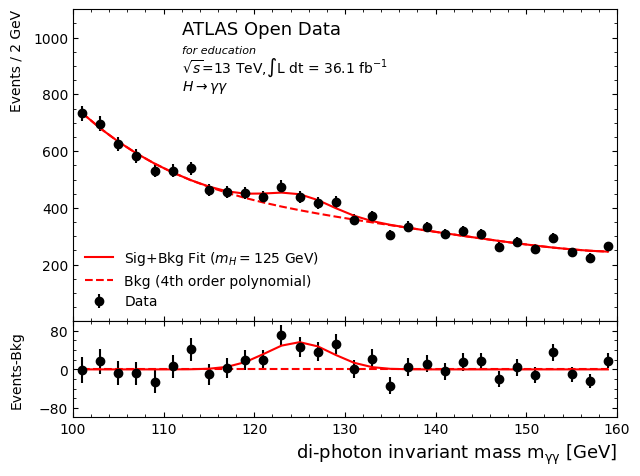

In [14]:

data_x,_ = np.histogram(ak.to_numpy(all_data['mass']), 
                            bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# data fit
polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
gaussian_mod = GaussianModel() # Gaussian

# set initial guesses for the parameters of the polynomial model
# c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                            x=bin_centres, c0=data_x.max(), c1=0,
                            c2=0, c3=0, c4=0 )

# set initial guesses for the parameters of the Gaussian model
pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                        x=bin_centres, amplitude=100, 
                        center=125, sigma=2 )

model = polynomial_mod + gaussian_mod # combined model

# fit the model to the data
out = model.fit(data_x, # data to be fit
                pars, # guesses for the parameters
                x=bin_centres, weights=1/data_x_errors ) #ASK

# background part of fit
params_dict = out.params.valuesdict() # get the parameters from the fit to data
c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4

# get the background only part of the fit to data
background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

# data fit - background fit = signal fit
signal_x = data_x - background 

# *************
# Main plot 
# *************
plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                fmt='ko', # 'k' means black and 'o' means circles
                label='Data' ) 

# plot the signal + background fit
main_axes.plot(bin_centres, # x
            out.best_fit, # y
            '-r', # single red line
            label='Sig+Bkg Fit ($m_H=125$ GeV)' )

# plot the background only fit
main_axes.plot(bin_centres, # x
            background, # y
            '--r', # dashed red line
            label='Bkg (4th order polynomial)' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    labelbottom=False, # don't draw tick labels on bottom axis
                    right=True ) # draw ticks on right axis

# write y-axis label for main 
main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                    horizontalalignment='right') 

# set the y-axis limit for the main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5 ) 

# set minor ticks on the y-axis of the main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# avoid displaying y=0 on the main axes
main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.2, # x
        0.92, # y
        'ATLAS Open Data', # text
        transform=main_axes.transAxes, # coordinate system used is that of main_axes
        fontsize=13 ) 

# Add text 'for education' on plot
plt.text(0.2, # x
        0.86, # y
        'for education', # text
        transform=main_axes.transAxes, # coordinate system used is that of main_axes
        style='italic',
        fontsize=8 ) 

lumi = 36.1
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.2, # x
        0.8, # y
        '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
        transform=main_axes.transAxes ) # coordinate system used is that of main_axes 

# Add a label for the analysis carried out
plt.text(0.2, # x
        0.74, # y
        r'$H \rightarrow \gamma\gamma$', # text 
        transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend(frameon=False, # no box around the legend
                loc='lower left' ) # legend location 


# *************
# Data-Bkg plot 
# *************
plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
sub_axes = plt.gca() # get the current axes

# set the y axis to be symmetric about Data-Background=0
sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                            symmetric=True) )

# plot Data-Background
sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                fmt='ko' ) # 'k' means black and 'o' means circles

# draw the fit to data
sub_axes.plot(bin_centres, # x
            out.best_fit-background, # y
            '-r' ) # single red line

# draw the background only fit
sub_axes.plot(bin_centres, # x
            background-background, # y
            '--r' )  # dashed red line

# set the x-axis limits on the sub axes
sub_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# x-axis label
sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    x=1, horizontalalignment='right', 
                    fontsize=13 ) 

# set the tick parameters for the sub axes
sub_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    right=True ) # draw ticks on right axis 

# separation of y-axis minor ticks
sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# y-axis label on the sub axes
sub_axes.set_ylabel( 'Events-Bkg' ) 


# Generic features for both plots
main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

And there it is—a clear peak in the invariant mass spectrum around 125 GeV, signaling the presence of the Higgs boson! While our main task may be done, there's still more to explore. Here are some additional tasks you can try with this notebook:

* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs boson discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0090) or the [Higgs decay to photons measurement paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Find the reduced chi-squared for the fit in '[Plotting](#plotting)'
* Find the mean of the fitted Gaussian in '[Plotting](#plotting)'
* Find the width of the fitted Gaussian in '[Plotting](#plotting)'
* Try different initial guesses for the parameters of the fit in '[Plotting](#plotting)'
* Try different functions for the fit in '[Plotting](#plotting)'
* Your idea!